# Loan default prediction

The problem is defined in the classification framework, where the predicted variable
is “Charge-Off ”. A charge-off is a debt that a creditor has given up trying to collect on
after you’ve missed payments for several months. The predicted variable takes value 1
in case of charge-off and 0 otherwise.

This case study aims to analyze data for loans through 2007-2017Q3 from Lending Club available on Kaggle. Dataset contains over 887 thousand observations and 150 variables among which one is describing the loan status.

In [1]:
try:
    # Try importing the SHAP library
    import shap
    print("SHAP is already installed.")

except ImportError:
    # If SHAP is not installed, install it using pip
    print("SHAP is not installed. Installing SHAP...")
    !pip install shap
    print("SHAP installed successfully.")


SHAP is already installed.


In [2]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap


from sklearn.metrics import classification_report, confusion_matrix, log_loss, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from sklearn.preprocessing import OneHotEncoder





In [3]:
def evaluate_classification_model(model, X_test, y_test, class_labels=['Not Charged Off', 'Charged Off']):
    """
    Evaluate a classification model and display various metrics.

    Parameters:
    - model: The trained machine learning model
    - X_test: Test set features
    - y_test: True labels for the test set
    - class_labels: List of labels for the classification task

    Returns:
    None
    """
    # Predictions for the test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_labels))

    # Log Loss
    log_loss_score = log_loss(y_test, y_pred_proba)
    print(f"Log Loss: {log_loss_score:.4f}")

    # F1 Score
    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()

    print(f"Area Under ROC (AUC): {roc_auc:.4f}")


In [4]:

# Load the dataset into a Pandas DataFrame
file_path = './13_german_credit_data.csv'
loans_df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame for initial exploration
loans_df.head()


,CheckingAccountStatus,Duration,CreditHistory,Purpose,CreditAmount,SavingsAccountBonds,PresentEmploymentSince,InstallmentRatePercentage,PersonalStatusSex,OtherDebtorsGuarantors,...,Property,Age,OtherInstallmentPlans,Housing,NumberOfExistingCredits,Job,NumberOfPeopleBeingLiable,Telephone,ForeignWorker,CreditRisk
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [5]:
# Check data types
data_info = loans_df.info()
data_info


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   CheckingAccountStatus      1000 non-null   object
 1   Duration                   1000 non-null   int64 
 2   CreditHistory              1000 non-null   object
 3   Purpose                    1000 non-null   object
 4   CreditAmount               1000 non-null   int64 
 5   SavingsAccountBonds        1000 non-null   object
 6   PresentEmploymentSince     1000 non-null   object
 7   InstallmentRatePercentage  1000 non-null   int64 
 8   PersonalStatusSex          1000 non-null   object
 9   OtherDebtorsGuarantors     1000 non-null   object
 10  PresentResidenceSince      1000 non-null   int64 
 11  Property                   1000 non-null   object
 12  Age                        1000 non-null   int64 
 13  OtherInstallmentPlans      1000 non-null   object
 14  Housing  

Identifying Categorical Columns

Need for One-Hot Encoding in Decision Trees
For many machine learning algorithms, one-hot encoding is necessary for the proper interpretation of categorical variables. For many tree based algorithms this is not the case( especcialy cat-boost).

However, the specific implementation in scikit-learn for models like DecisionTreeClassifier, RandomForestClassifier, and GradientBoostingClassifier does not natively support categorical variables.

We will then need to onehotencode our data.

In [6]:
# Detect categorical columns
categorical_cols = loans_df.select_dtypes(include=['object', 'category']).columns

# Initialize encoder
encoder = OneHotEncoder(
    drop='first',
    sparse_output=False,
    dtype=int,
    handle_unknown='ignore'
).set_output(transform='pandas')

encoded_df = (
    encoder
    .fit_transform(loans_df[categorical_cols])
    .astype("Int64")
)


In [7]:
encoded_loans_df = loans_df.drop(columns=categorical_cols).join(encoded_df)
encoded_loans_df.head()

,Duration,CreditAmount,InstallmentRatePercentage,PresentResidenceSince,Age,NumberOfExistingCredits,NumberOfPeopleBeingLiable,CreditRisk,CheckingAccountStatus_A12,CheckingAccountStatus_A13,...,Property_A124,OtherInstallmentPlans_A142,OtherInstallmentPlans_A143,Housing_A152,Housing_A153,Job_A172,Job_A173,Job_A174,Telephone_A192,ForeignWorker_A202
0,6,1169,4,4,67,2,1,1,0,0,...,0,0,1,1,0,0,1,0,1,0
1,48,5951,2,2,22,1,1,2,1,0,...,0,0,1,1,0,0,1,0,0,0
2,12,2096,2,3,49,1,2,1,0,0,...,0,0,1,1,0,1,0,0,0,0
3,42,7882,2,4,45,1,2,1,0,0,...,0,0,1,0,1,0,1,0,0,0
4,24,4870,3,4,53,2,2,2,0,0,...,1,0,1,0,1,0,1,0,0,0


Let's seperate X and Y and split our data:

In [8]:
# Features (X) and Target (y) variables
X = encoded_loans_df.drop('CreditRisk', axis=1)
y = loans_df['CreditRisk'] -1

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display the shape of the resulting sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 48), (200, 48), (800,), (200,))

The DecisionTreeClassifier in scikit-learn offers several hyperparameters that control various aspects of the tree. Some notable ones are:

* criterion: The function to measure the quality of a split. Supported criteria are "gini" for Gini impurity and "entropy" for information gain.
* splitter: The strategy used to choose the split at each node. Options are "best" to choose the best split and "random" to choose the best random split.
* max_depth: The maximum depth of the tree.
* min_samples_split: The minimum number of samples required to split an internal node.
* min_samples_leaf: The minimum number of samples required to be at a leaf node.

Applying with Default Parameters

Let's first build a decision tree using the default parameters and evaluate its performance using log loss as the metric. Log loss provides a measure of uncertainty and is sensitive to the probabilities assigned to each class, making it a good choice for imbalanced datasets.

In [9]:
# Initialize the DecisionTreeClassifier with default parameters

# Fit the model to the training data using cross_val_score cv=5 and log loss as the scoring metric
cv_results_dt = cross_val_score(DecisionTreeClassifier(random_state=42), X_train, y_train, cv=5, scoring='neg_log_loss')
cv_results_dt

array([-12.61527869,  -9.91200468, -10.36255035, -10.81309602,
       -10.58782318])

In [10]:
print("Average 5-Fold CV Log Loss: {}".format(round(abs(np.mean(cv_results_dt)), 3)))

Average 5-Fold CV Log Loss: 10.858


Ok we have a starting point, but our decision tree requires parameters. Let's apply what we have learned about cross validaiton and hyperparameter tuning. Let's search the following grid or potential paramters:

```
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [2, 5, 10]
}
```

In [11]:

# Define hyperparameter grid

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [2, 5, 10]
}
# Initialize the GridSearchCV object
grid_search_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    #scoring='neg_log_loss',
    scoring='neg_log_loss',
    cv=5,
    n_jobs=-1,
    verbose=1
)


# Fit the model to the training data
grid_search_dt.fit(X_train, y_train)

# Best hyperparameters and score
best_params = grid_search_dt.best_params_
print(f"Best Parameters: {best_params}")
print(f"Best Score: {grid_search_dt.best_score_:.4f}")
print(f"Best Score (Log Loss): {abs(grid_search_dt.best_score_):.4f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 10}
Best Score: -4.8339
Best Score (Log Loss): 4.8339


A big improvement. But we have another way to improve our decision trees...

**Pruning** is generally applied to combat overfitting. A decision tree that is too deep tends to capture noise and makes the model complex, thereby failing to generalize well to unseen data. The max_depth parameter essentially acts as a pruning mechanism. Another explicit pruning strategy is to use ccp_alpha, a complexity parameter used for Minimal Cost-Complexity Pruning. A tree with a greater ccp_alpha will be more pruned, hence simpler.

The Cost-Complexity Pruning parameter (ccp_alpha) penalizes the tree for its complexity. The higher the ccp_alpha, the simpler the tree will be. To demonstrate, let's fit the model with the same hyperparameters as before but with varying ccp_alpha values, and observe the impact on log loss.

We could set ccp_alpha using GridSearchCV as we have previosuly seen. Here we ho this manually

In [12]:
# Define hyperparameter grid with ccp_alpha values
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'ccp_alpha': [0.0, 0.001, 0.01, 0.05, 0.1]
}

# Initialize GridSearchCV
grid_search_dt_pruned = GridSearchCV(
    estimator=DecisionTreeClassifier( random_state=42),#**best_params,
    param_grid=param_grid,
    scoring='neg_log_loss',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the model to the training data
grid_search_dt_pruned.fit(X_train, y_train)

# Best hyperparameters and score
best_ccp_alpha = grid_search_dt_pruned.best_params_
print(f"Best ccp_alpha: {best_ccp_alpha}")
print(f"Best Score: {grid_search_dt_pruned.best_score_:.4f}")
print(f"Best Score (Log Loss): {abs(grid_search_dt_pruned.best_score_):.4f}")


Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best ccp_alpha: {'ccp_alpha': 0.05, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}
Best Score: -0.5565
Best Score (Log Loss): 0.5565


Pruning helped!

Let's fit our final classifier on all our training data and test it's performance on the test data.

In [13]:
# Initialize the DecisionTreeClassifier with the assumed parameters
dt_classifier_final = DecisionTreeClassifier(**best_ccp_alpha, random_state=42)

# Fit the model to the training data
dt_classifier_final.fit(X_train, y_train)




,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'entropy'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the curren

Classification Report:
                 precision    recall  f1-score   support

Not Charged Off       0.70      1.00      0.82       140
    Charged Off       0.00      0.00      0.00        60

       accuracy                           0.70       200
      macro avg       0.35      0.50      0.41       200
   weighted avg       0.49      0.70      0.58       200

Log Loss: 0.5458
F1 Score: 0.0000


d:\nmr-git\novaIMS-machinelearning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\nmr-git\novaIMS-machinelearning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\nmr-git\novaIMS-machinelearning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

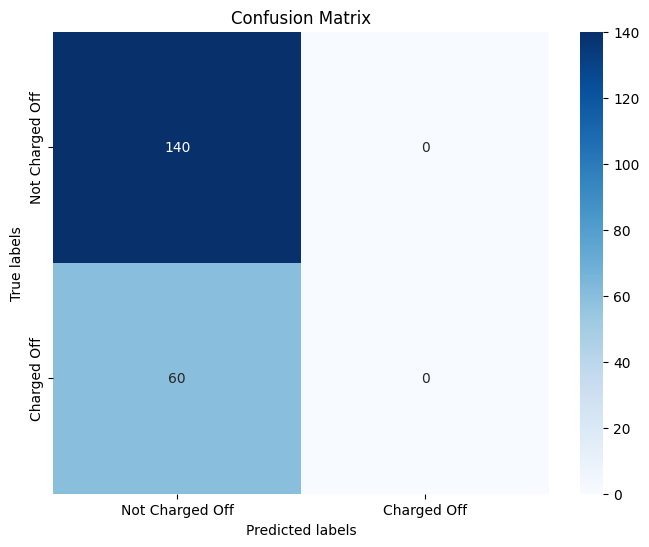

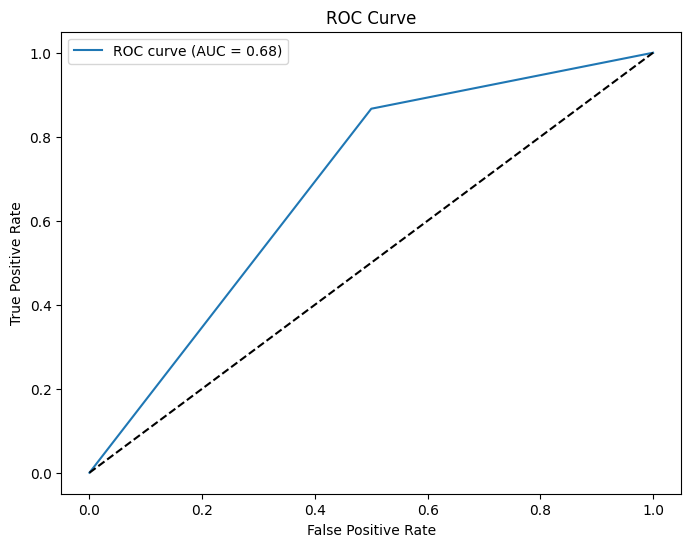

Area Under ROC (AUC): 0.6833


array([-12.61527869,  -9.91200468, -10.36255035, -10.81309602,
       -10.58782318])

In [14]:
# use the function evaluate_classification_model to see our results
evaluate_classification_model(dt_classifier_final, X_test, y_test)
cv_results_dt = cross_val_score(DecisionTreeClassifier(random_state=42), X_train, y_train, cv=5, scoring='neg_log_loss')
cv_results_dt

### Visualizing the Decision Tree

Visualizing a decision tree can provide valuable insights into the decision-making process of the model. It allows us to understand the splits and conditions that the tree uses to make predictions.

To visualize the decision tree, we can use the plot_tree function from the sklearn.tree module. Due to the potentially large size of the tree, it's often practical to limit the depth of the tree displayed.

Let's proceed with the visualization of the Decision Tree model we've just trained, limiting the depth for better readability.

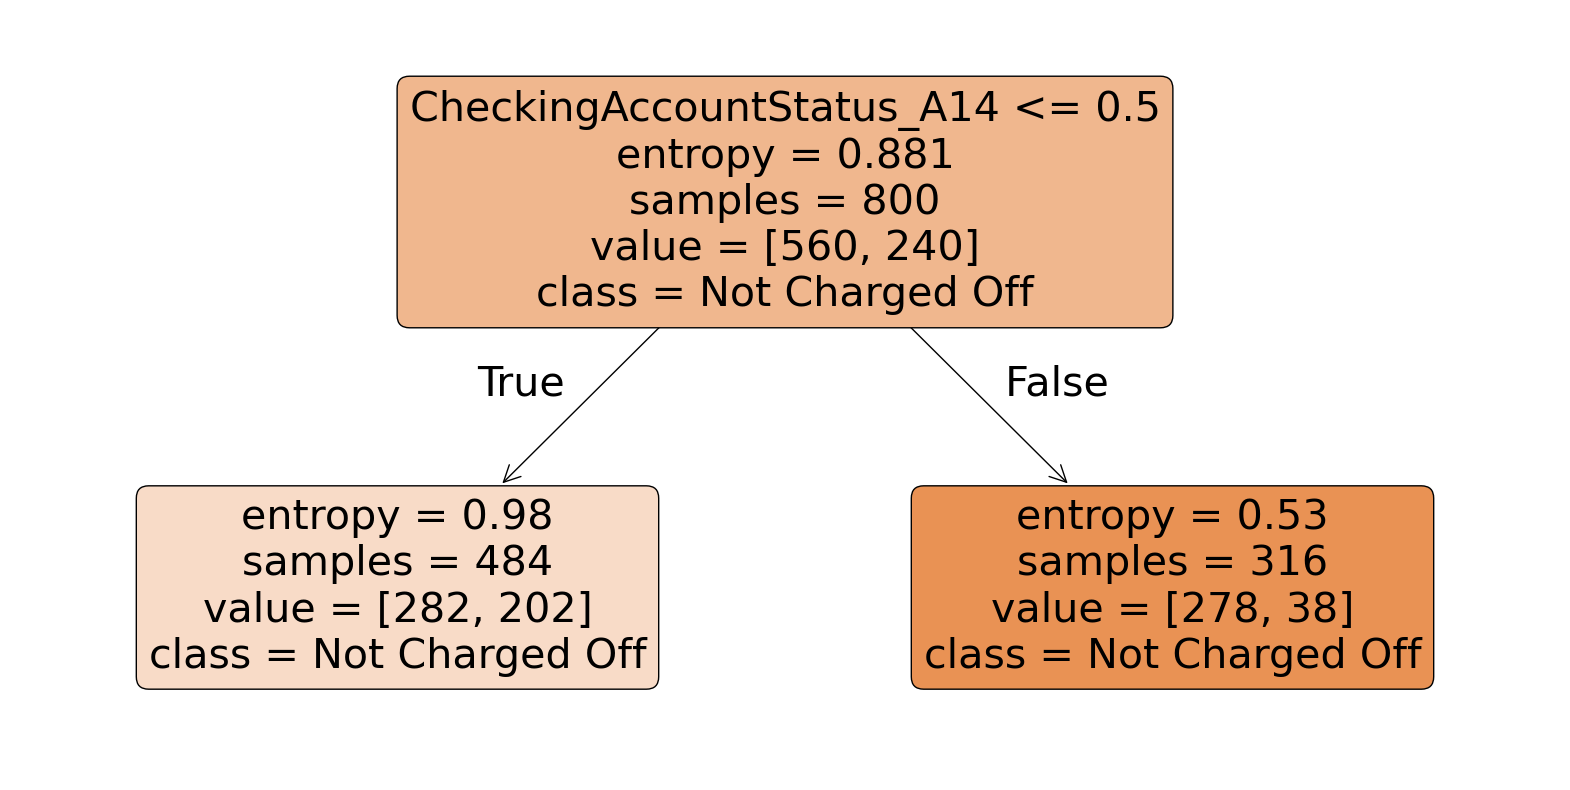

In [15]:
# Initialize the plot
plt.figure(figsize=(20, 10))

# Plot the tree, limiting the depth to 3 levels for better readability
plot_tree(dt_classifier_final, filled=True, rounded=True, max_depth=3, feature_names=X_train.columns.to_list(), class_names=['Not Charged Off', 'Charged Off'])

# Show the plot
plt.show()


We don't have a great classifier!

Let's explore balanced class weights and f1 as our metric.

In [16]:
# Define hyperparameter grid with balanced class weights
param_grid_balanced = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'ccp_alpha': [0.0, 0.001, 0.01, 0.05, 0.1],
    'class_weight': ['balanced']
}

# Initialize GridSearchCV with F1 as the scoring metric
grid_search_dtb = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_balanced,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the model to the training data
grid_search_dtb.fit(X_train, y_train)

# Best hyperparameters and score
best_params_balanced = grid_search_dtb.best_params_
print(f"Best Parameters: {best_params_balanced}")
print(f"Best F1 Score: {grid_search_dtb.best_score_:.4f}")

# Extract the best model
dtb_model = grid_search_dtb.best_estimator_

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best Parameters: {'ccp_alpha': 0.05, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}
Best F1 Score: 0.5584


Classification Report:
                 precision    recall  f1-score   support

Not Charged Off       0.90      0.50      0.64       140
    Charged Off       0.43      0.87      0.57        60

       accuracy                           0.61       200
      macro avg       0.66      0.68      0.61       200
   weighted avg       0.76      0.61      0.62       200

Log Loss: 0.6195
F1 Score: 0.5714


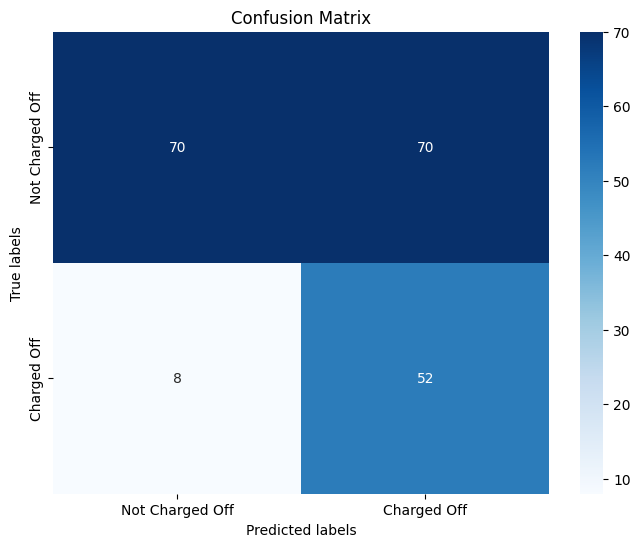

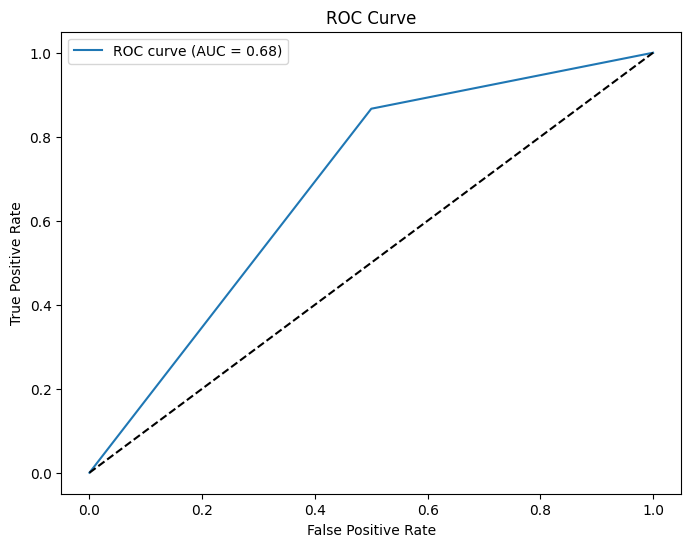

Area Under ROC (AUC): 0.6833


In [17]:
# Evaluate the balanced model on test data
evaluate_classification_model(dtb_model, X_test, y_test)

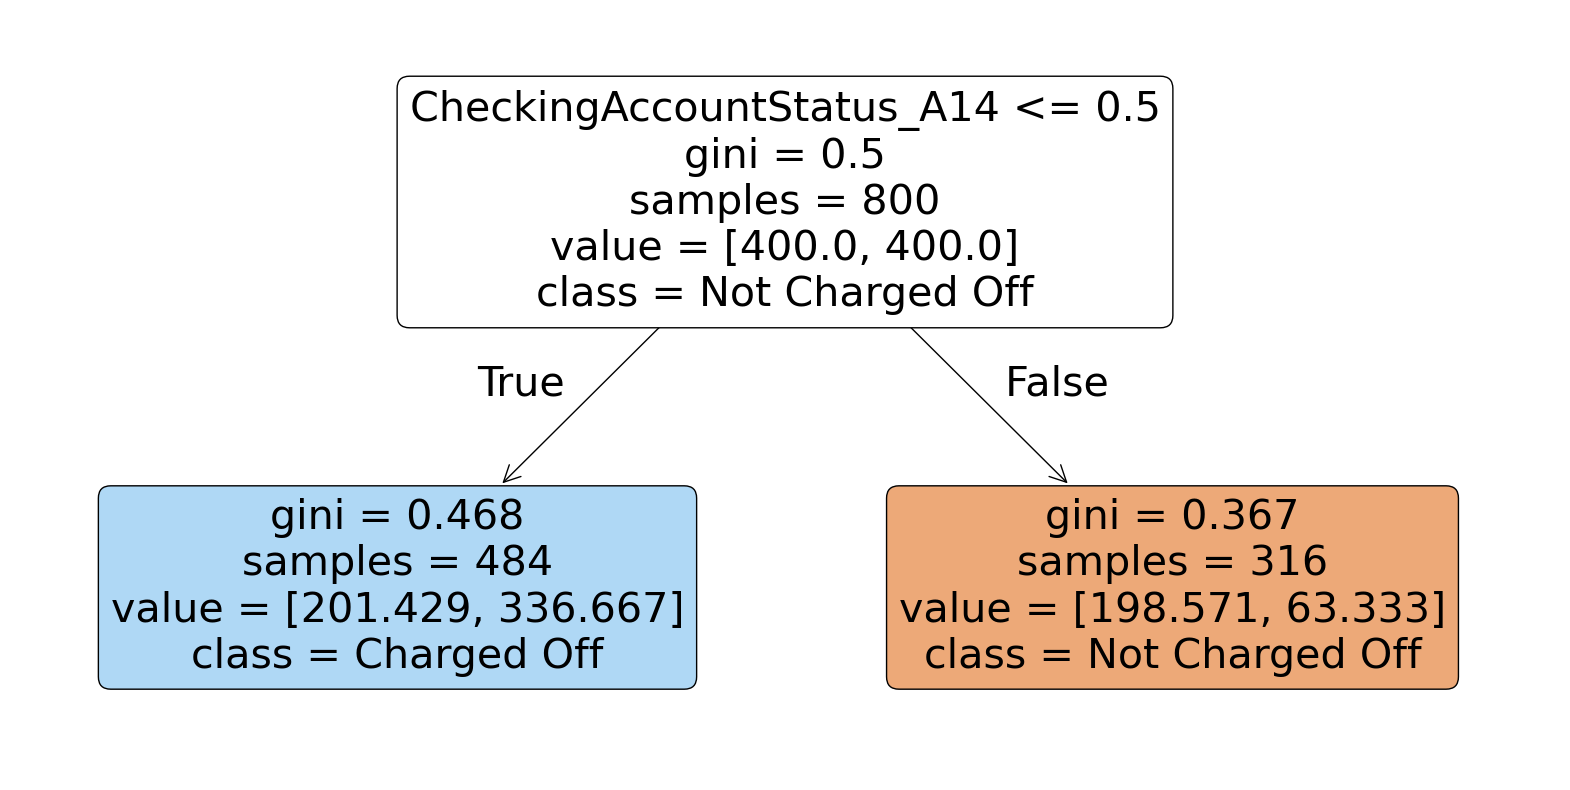

In [19]:
# Initialize the plot
plt.figure(figsize=(20, 10))

# Plot the tree, limiting the depth to 5 levels for better readability
plot_tree(dtb_model, filled=True, rounded=True, max_depth=5, feature_names=X_train.columns.to_list(), class_names=['Not Charged Off', 'Charged Off'])

# Show the plot
plt.show()


### Decision Trees vs Random Forests

#### Decision Trees:
1. **Simplicity**: A single decision tree is simple to understand and interpret. It makes decisions by splitting the feature space based on feature importance.
2. **Prone to Overfitting**: A deep tree tends to fit noise in the data, leading to poor generalization on new, unseen data.
3. **Deterministic**: The same set of rules (tree structure) will always be generated for a given dataset, making the model deterministic.

#### Random Forests:
1. **Ensemble Method**: A Random Forest is an ensemble of decision trees, typically trained via the bagging method.
2. **Robust to Overfitting**: By averaging over multiple decision trees, the Random Forest is less likely to overfit to the training data.
3. **Stochasticity**: The method introduces randomness in two ways: by bootstrapping samples and by considering a random subset of features for each split.
4. **Higher Complexity**: Random Forests are generally more complex and computationally expensive compared to a single decision tree.

### Key Parameters in RandomForestClassifier

- `n_estimators`: Number of trees in the forest.
- `criterion`: The function to measure the quality of a split ('gini' or 'entropy').
- `max_depth`: The maximum depth of the tree.
- `min_samples_split`: The minimum number of samples required to split an internal node.
- `min_samples_leaf`: The minimum number of samples required to be at a leaf node.
- `max_features`: The number of features to consider when looking for the best split.
- `bootstrap`: Whether bootstrap samples are used when building trees.
- `class_weight`: Weights associated with classes, useful for imbalanced datasets.




In [20]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10],
    'min_samples_split': [2, 0.01],
    'class_weight': ['balanced']
}

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search_rf.fit(X_train, y_train)
rf_best_param = grid_search_rf.best_params_
print(rf_best_param)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 0.01, 'n_estimators': 100}


In [21]:
# we can extract the rf model directly from the grid search object
rf_classifier_best = grid_search_rf.best_estimator_

In [22]:
# Number of trees in the final forest (Random Forest model: rf_classifier)
num_trees = len(rf_classifier_best.estimators_)
print(f"Number of trees in the final forest: {num_trees}")


Number of trees in the final forest: 100


Classification Report:
                 precision    recall  f1-score   support

Not Charged Off       0.93      0.77      0.84       560
    Charged Off       0.62      0.86      0.72       240

       accuracy                           0.80       800
      macro avg       0.77      0.82      0.78       800
   weighted avg       0.84      0.80      0.81       800

Log Loss: 0.5239
F1 Score: 0.7213


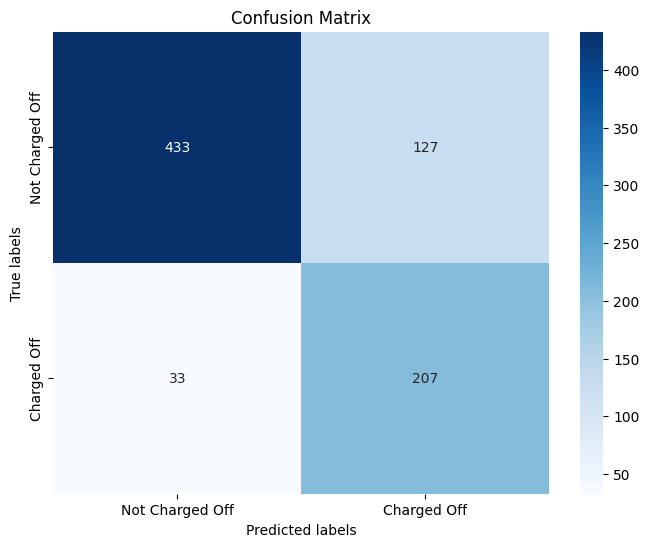

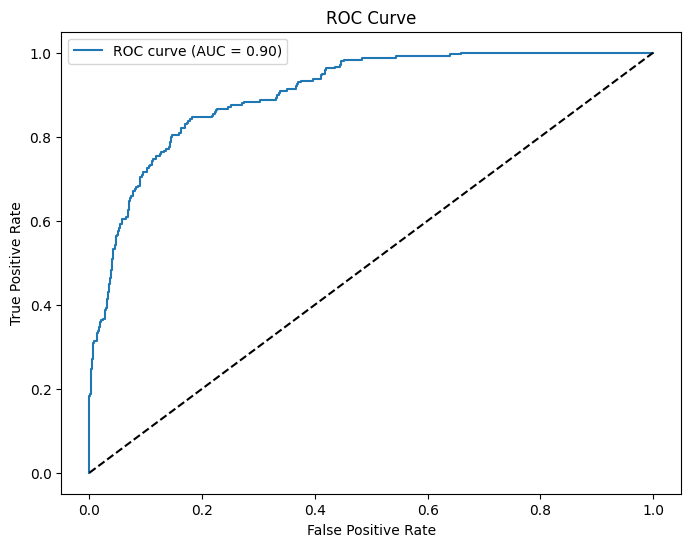

Area Under ROC (AUC): 0.9049


In [23]:
evaluate_classification_model(rf_classifier_best, X_train, y_train)

#### Exploring Feature Importance
Random Forests have the advantage of offering a straightforward way to assess feature importance. This is done by looking at the average impurity decrease computed from all decision trees in the forest. Alternatively, one can also look at how much each feature decreases the impurity when it is used for splitting.

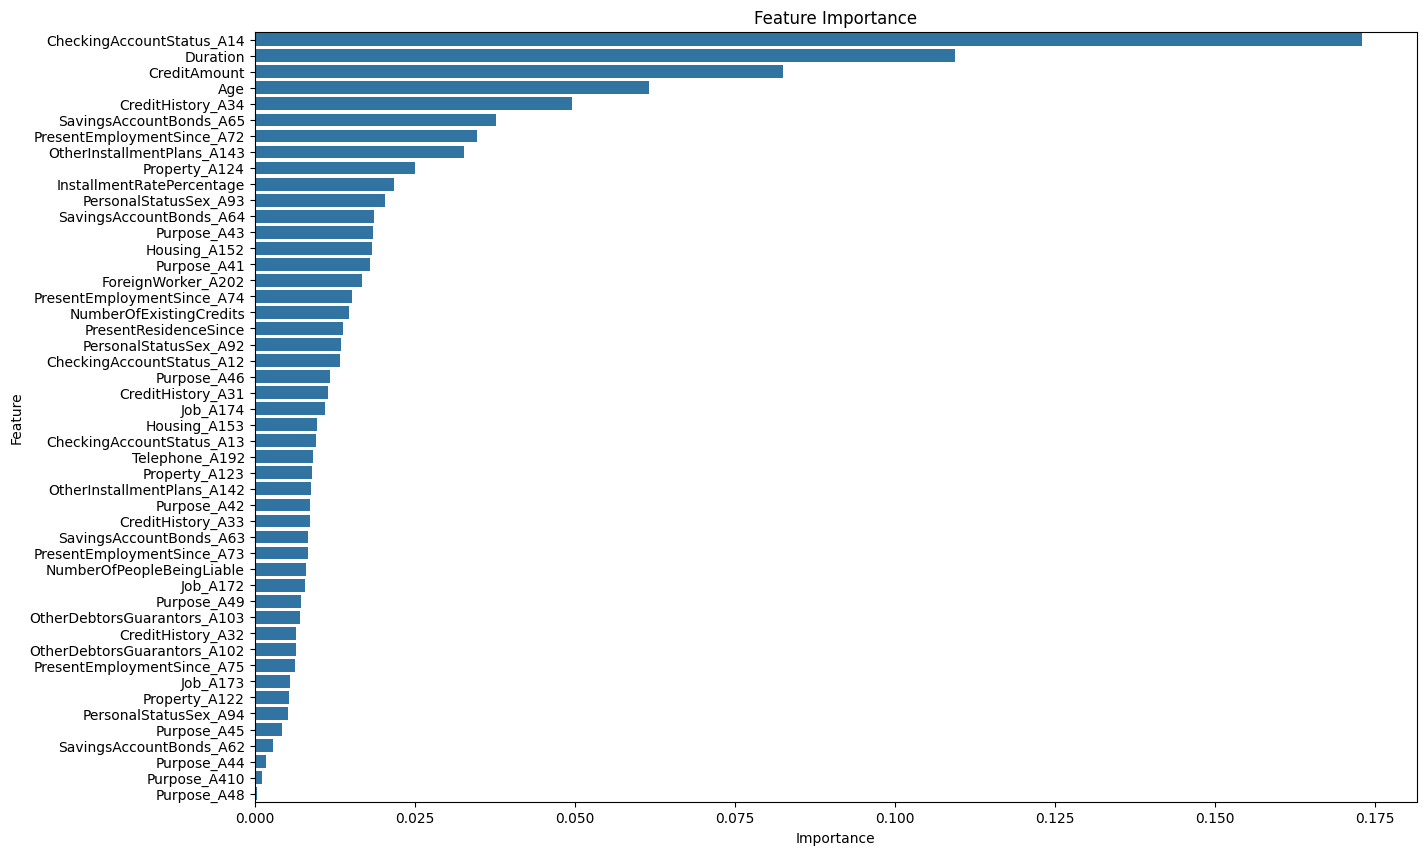

In [24]:
# Extract feature importances
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_classifier_best.feature_importances_
})

# Sort by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(15, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance')
plt.show()


Partial Dependence Plots:

These plots show the marginal effect one or two features have on the predicted outcome. They capture the way a model depends on the features and can be used for both classification and regression models.

https://scikit-learn.org/stable/modules/generated/sklearn.inspection.PartialDependenceDisplay.html

The process of generating a PDP involves the following steps, which are focused entirely on making predictions:

* Fixing Feature Values: For a given feature (or a pair of features in the case of interaction effects), a range of values is selected. These values typically span the range observed in the dataset.

* Altering Dataset: For each value in this range, the dataset is altered such that the feature(s) of interest are set to this fixed value, while all other features remain unchanged.

* Making Predictions: The trained model then makes predictions for each of these altered datasets. This step does not involve any training or modification of the model itself; it simply uses the model to predict outcomes based on the modified input data.

* Averaging Predictions: The predictions across these datasets are averaged to obtain a measure of the marginal effect of the feature(s) on the model's prediction. This average is what is plotted in a PDP.

Note: This method is a little slow for random forests, because it needs to make lot's of predictions, and to do this random forests needs to use lot's of trees! I have reduced the data to be used with `subsample` and the number of values to be tested for each feature with `grid_resolution`

d:\nmr-git\novaIMS-machinelearning\.venv\Lib\site-packages\sklearn\inspection\_partial_dependence.py:721: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
d:\nmr-git\novaIMS-machinelearning\.venv\Lib\site-packages\sklearn\inspection\_partial_dependence.py:721: FutureWarning: The column 4 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
d:\nmr-git\novaIMS-machinelearning\.venv\Lib\site-packages\s

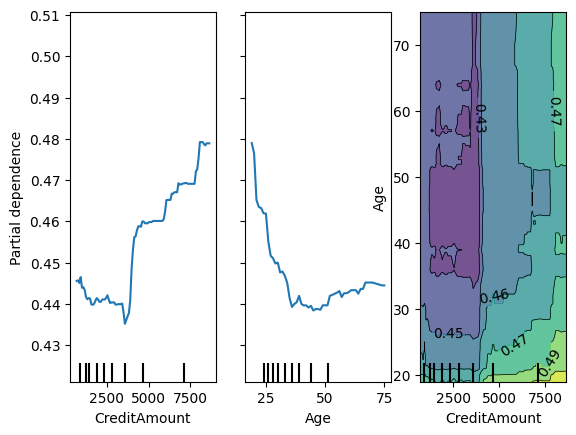

In [25]:
# Plotting partial dependence for the first feature and interaction between the first and second features
PartialDependenceDisplay.from_estimator(rf_classifier_best, X_train, [1,4, (1, 4)])


# Show the plot
plt.show()

### SHAP (SHapley Additive exPlanations)

SHAP is a powerful tool for interpreting machine learning models based on game theory. It provides a way to allocate the contribution of each feature for a particular prediction in a consistent and theoretically justified manner. SHAP values offer high-level interpretability without sacrificing accuracy, and they can be used with any machine learning model, though they are most commonly used with tree-based models like Gradient Boosted Trees (GBTs).

https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

### Why Use SHAP?

1. **Consistency**: If a model changes such that a feature has a larger impact on the output, the SHAP value for that feature should also change in the same direction.
2. **Local Accuracy**: The sum of the SHAP values for a prediction plus the base value should equal the model's output for that instance.
3. **Fair Allocation**: The sum of all feature attributions should sum up to the total prediction minus the base value for each instance.

### Key SHAP Visualizations:

1. **Summary Plot**: Provides an overview of the impact of all features on the model's output.
2. **Force Plot**: Visualizes the features pushing a particular prediction higher or lower.
3. **Dependence Plot**: Shows how the model output changes with a single feature.


In [28]:

# Initialize the explainer object with your trained GBT model
# Convert X_test to a float type to avoid the TypeError
X_test_numeric = X_test.astype(float)
explainer = shap.TreeExplainer(rf_classifier_best, X_test_numeric)

# Compute SHAP values for the entire test set
shap_values = explainer.shap_values(X_test_numeric)

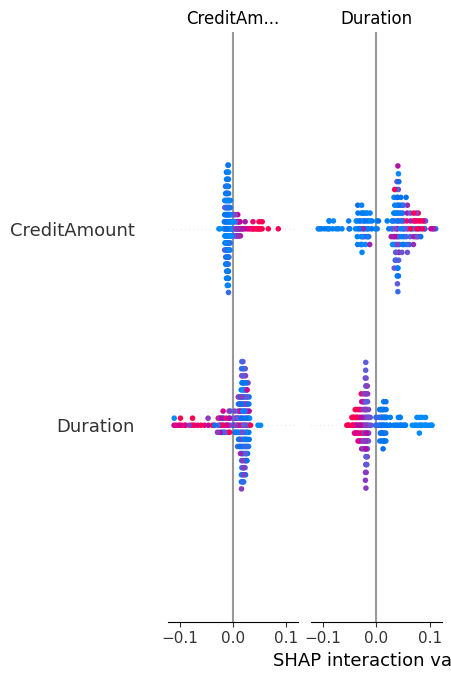

In [29]:
shap.summary_plot(shap_values, X_test)

### Gradient Boosted Trees (GBTs) vs Random Forests

#### Gradient Boosted Trees:

1. **Sequential Learning**: Builds one tree at a time, where each new tree corrects the errors of the previous one.
2. **Focus on Error**: Concentrates more on the instances that are hard to classify.
3. **Less Randomness**: Unlike Random Forest, there's no bootstrapping of data.
4. **Regularization**: Incorporates parameters to regularize the model, reducing the risk of overfitting.
5. **Sensitive to Noisy Data**: Since it emphasizes misclassified points, it might give weight to outliers or noise.
  
#### Random Forests:

1. **Parallel Learning**: Builds multiple trees in parallel.
2. **Equal Focus**: Treats all instances equally.
3. **Bootstrapping**: Utilizes bootstrapping to create different subsets of data.
4. **No Regularization**: Less prone to overfitting but does not have built-in regularization.
5. **Robust to Noisy Data**: Due to averaging across multiple trees, Random Forests are usually robust to outliers and noise.

### Key Parameters in GradientBoostingClassifier

- `n_estimators`: Number of boosting stages, i.e., the number of trees.
- `learning_rate`: A factor to shrink the contribution of each tree (regularization).
- `max_depth`: Maximum depth of the individual regression estimators (trees).
- `min_samples_split`: The minimum number of samples required to split an internal node.
- `min_samples_leaf`: The minimum number of samples required to be at a leaf node.
- `subsample`: Fraction of samples used for fitting the trees.
  
What Does subsample Do?

When subsample=1.0 (default), all training samples are used to build each tree, and no sampling is performed. This is similar to traditional boosting.
When 0 < subsample < 1.0, only a fraction of the training samples are used to fit each base learner. For instance, if subsample=0.8, each tree is trained on 80% of the total training samples, chosen randomly.

Trade-offs:
* Higher Value: More accurate individual trees, but risk of overfitting.
* Lower Value: More regularization and faster training, but individual trees may be less accurate.


## Exercise:

Use grid search and CV to find the parameters for `GradientBoostingClassifier`. A Grid serach object is provided below. Set the scoring to "f1".

In [30]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 0.1]
}


# Initialize GridSearchCV
grid_search_gbt = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# The following line would fit the model, but we won't run it here
grid_search_gbt.fit(X_train, y_train)
gbt_classifier_best = grid_search_gbt.best_estimator_


Fitting 5 folds for each of 36 candidates, totalling 180 fits


Use the ´evaluate_classification_model´ to check how the model is performing.

Classification Report:
                 precision    recall  f1-score   support

Not Charged Off       0.82      0.86      0.84       140
    Charged Off       0.64      0.57      0.60        60

       accuracy                           0.78       200
      macro avg       0.73      0.72      0.72       200
   weighted avg       0.77      0.78      0.77       200

Log Loss: 0.4850
F1 Score: 0.6018


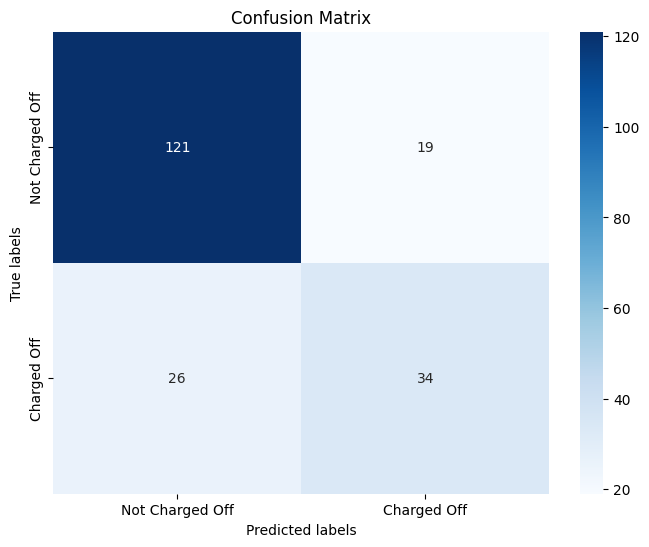

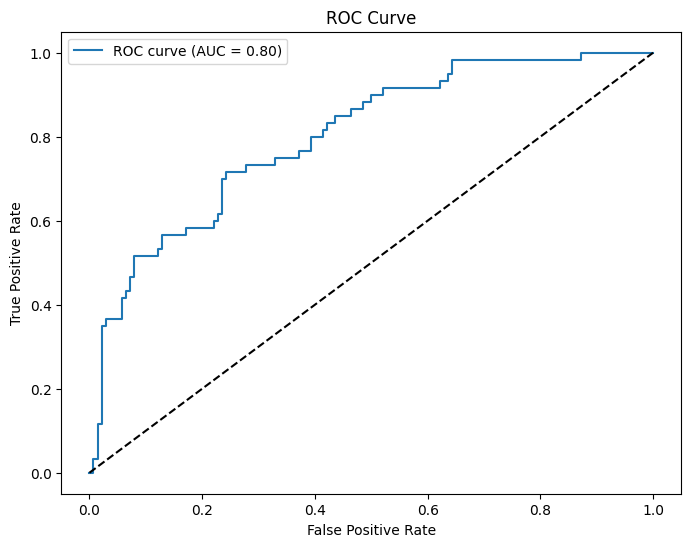

Area Under ROC (AUC): 0.8021


In [31]:
evaluate_classification_model(gbt_classifier_best, X_test, y_test)

Plot feature importances

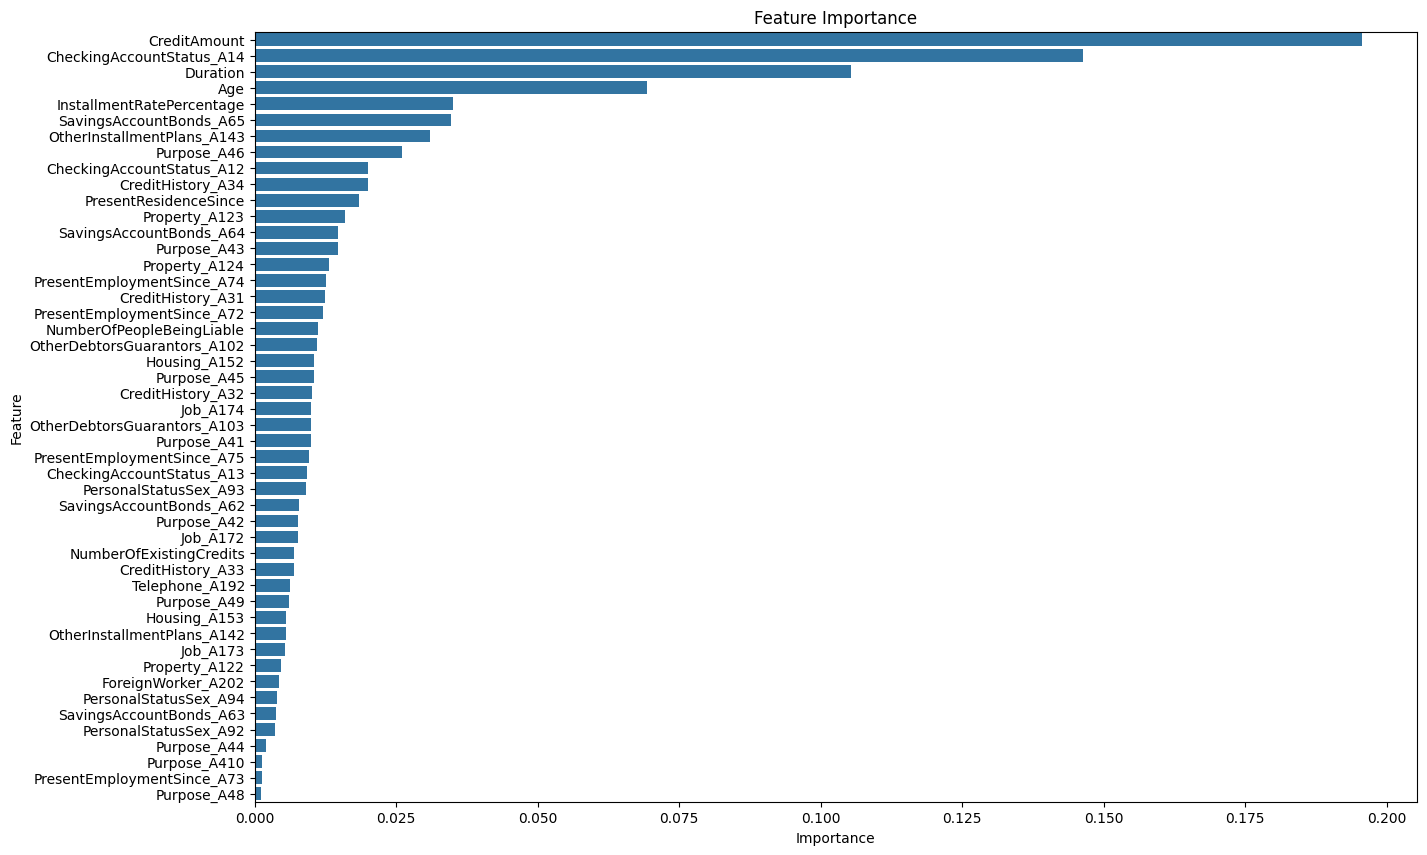

In [32]:
# Extract feature importances
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': gbt_classifier_best.feature_importances_
})

# Sort by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(15, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance')
plt.show()

Plot partial dependence of Credit Duration and Age.

d:\nmr-git\novaIMS-machinelearning\.venv\Lib\site-packages\sklearn\inspection\_partial_dependence.py:721: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
d:\nmr-git\novaIMS-machinelearning\.venv\Lib\site-packages\sklearn\inspection\_partial_dependence.py:721: FutureWarning: The column 4 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
d:\nmr-git\novaIMS-machinelearning\.venv\Lib\site-packages\s

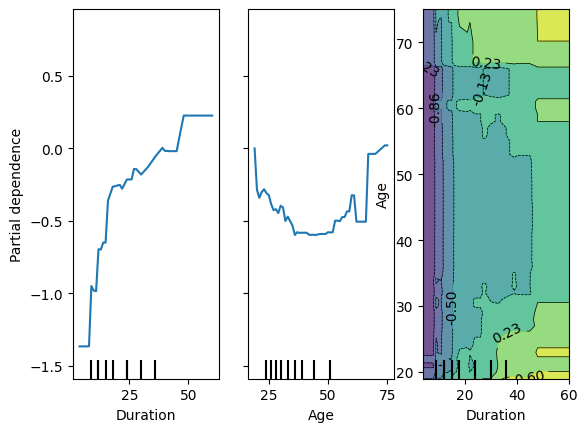

In [33]:
# Plotting partial dependence for the first feature and interaction between the first and second features
PartialDependenceDisplay.from_estimator(gbt_classifier_best, X_train, [0,4, (0, 4)])

# Show the plot
plt.show()

Create a summary plot whith shap:


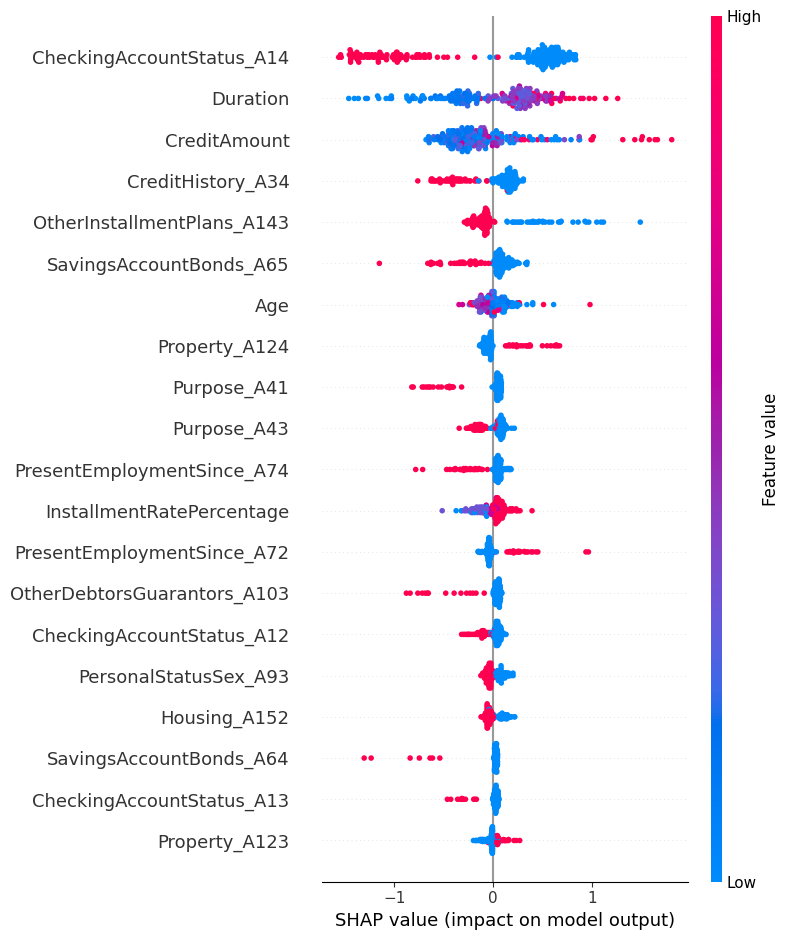

In [34]:
# Initialize the explainer object with your trained GBT model
X_test_numeric = X_test.astype(float)
explainer = shap.TreeExplainer(gbt_classifier_best, X_test_numeric)


# Compute SHAP values for the entire test set
shap_values = explainer.shap_values(X_test_numeric)

# Create the summary plot
shap.summary_plot(shap_values, X_test)


Interpretation:
* Higher (or Lower) Impact: Features at the top of the plot are typically those that have greater impact on the model's output. The "impact" is often computed based on the mean absolute SHAP value for each feature across the dataset.

* Direction of Impact: Dots to the right of the zero line on the x-axis typically indicate a positive impact on the prediction, while dots to the left indicate a negative impact.

* Magnitude of Impact: The further a dot is from the zero line on the x-axis, the larger the impact that particular feature value had on the prediction for that instance.

* Feature Value: The color of the dot represents the value of the feature. This can help you understand how different ranges of feature values are influencing the output.

## Exercise

See if pruning or stochastic gradient boosting improves the model, check parameters on:

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

Fitting 5 folds for each of 768 candidates, totalling 3840 fits
Best Parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.8}
Best F1 Score: 0.5213

Comparison with previous model:
Previous Best F1: 0.5182
Enhanced Best F1: 0.5213
Improvement: 0.0031

Enhanced Model Performance on Test Set:
Classification Report:
                 precision    recall  f1-score   support

Not Charged Off       0.80      0.89      0.84       140
    Charged Off       0.64      0.48      0.55        60

       accuracy                           0.77       200
      macro avg       0.72      0.68      0.70       200
   weighted avg       0.75      0.77      0.75       200

Log Loss: 0.5022
F1 Score: 0.5524


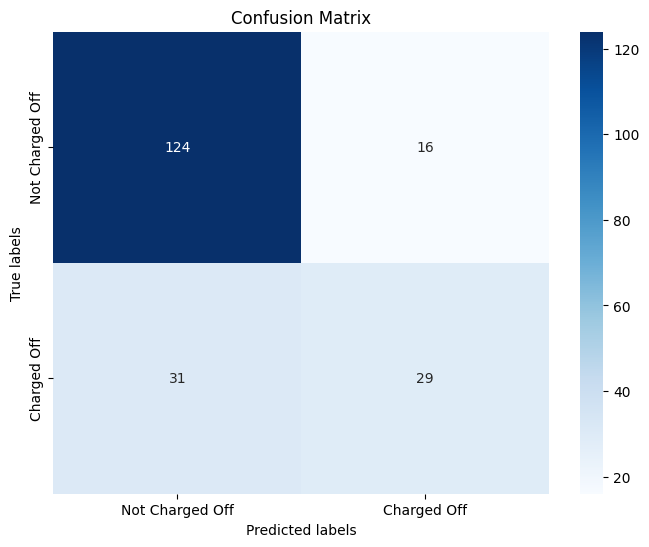

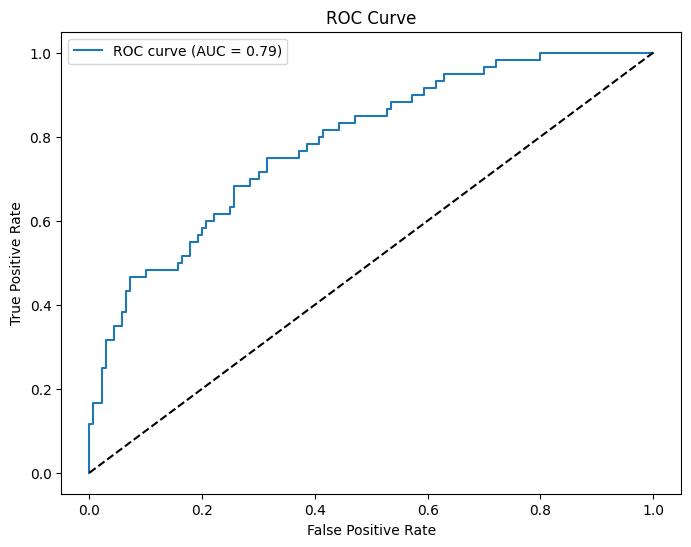

Area Under ROC (AUC): 0.7867


In [ ]:
# Define enhanced hyperparameter grid with pruning and stochastic gradient boosting
param_grid_enhanced = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 10, 15],
    'min_samples_split': [2, 0.1],
    'subsample': [0.8, 1.0],  # Stochastic gradient boosting (< 1.0 means stochastic)
    'ccp_alpha': [0.0, 0.001, 0.01,0.1,1,10],  # Pruning parameter
    'criterion': ['friedman_mse', 'squared_error']
}

# Initialize GridSearchCV with enhanced parameters
grid_search_gbt_enhanced = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid_enhanced,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit the model
grid_search_gbt_enhanced.fit(X_train, y_train)

# Extract best model and parameters
gbt_classifier_enhanced = grid_search_gbt_enhanced.best_estimator_
best_params_enhanced = grid_search_gbt_enhanced.best_params_

print(f"Best Parameters: {best_params_enhanced}")
print(f"Best F1 Score: {grid_search_gbt_enhanced.best_score_:.4f}")
print(f"\nComparison with previous model:")
print(f"Previous Best F1: {grid_search_gbt.best_score_:.4f}")
print(f"Enhanced Best F1: {grid_search_gbt_enhanced.best_score_:.4f}")
print(f"Improvement: {(grid_search_gbt_enhanced.best_score_ - grid_search_gbt.best_score_):.4f}")

# Evaluate on test set
print("\n" + "="*50)
print("Enhanced Model Performance on Test Set:")
print("="*50)
evaluate_classification_model(gbt_classifier_enhanced, X_test, y_test)